# Table of Contents
* [CK12 flexbook pdf extraction](#CK12-flexbook-pdf-extraction)
	* [pdfminer drawing boxes](#pdfminer-drawing-boxes)
	* [extracting and refining](#extracting-and-refining)
	* [counting question types](#counting-question-types)
	* [finding stopwords](#finding-stopwords)
	* [font color and size counts](#font-color-and-size-counts)
* [End](#End)


In [64]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict
%load_ext autoreload
%autoreload 2

import cv2
import os
import pprint
import pickle
import json
import requests
import io
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image

from copy import deepcopy
import pdfextraction.pdf_processing as pdf_processing

In [5]:
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [6]:
import pdfextraction.ck12_flex_extract as ck_ex

# CK12 quiz extraction

This notebook compares the OCR results embedded in the textbook scans to those of eric's api, and MS oxford alone

In [118]:
text_path = './ck12_pdfs/text/'
life_sci_text = 'CK-12-Life-Science-For-Middle-School_b_v77_dzc_s1.pdf'
earth_sci_text ='CK-12-Earth-Science-For-Middle-School_b_v39_yq9_s1.pdf'
phys_sci_text ='CK-12-Physical-Science-For-Middle-School_b_v45_cmw_s1.pdf'

#  '/Users/schwenk/wrk/science_tb_anno/ck12/pdf_quizzes/'
quiz_path = '/Users/schwenk/wrk/stb/ck12/docx-quizes/converted-to-pdfs/'

es_dir ='earth-science'
ls_dir ='life-science'
ps_dir =  'physical-science'

subject_dirs = [es_dir, ls_dir, ps_dir]
# subject_dirs = [es_dir]

quiz_names = !ls /Users/schwenk/wrk/stb/ck12/docx-quizes/converted-to-pdfs/*science/*
len(quiz_names)

848

## pdfminer drawing boxes

In [277]:
def get_deepest_nested_component(layout_comp):
    if hasattr(layout_comp, '_objs'):
        return get_first_nested_component(layout_comp._objs[0])
    else:
        return layout_comp

def check_for_topic_header(text_box, header_font):
    first_char = get_deepest_nested_component(text_box)
    if hasattr(first_char, 'fontname'):
        box_font = first_char.fontname.split('_')[-1]
        print box_font
        return box_font == header_font
    else:
        return False

def process_line(text_box):
    return check_for_topic_header(text_box)

def process_page(page_layout, header_font = 'Bold'):
    for box in page_layout:
        print box
        header_found = check_for_topic_header(box, header_font)

# test_page_layout[0]._objs


'KCJNMV+NimbusRomNo9L-Regu-Slant_167'

to1 = test_page_layout[0]._objs[2]._objs[0]._objs[0]

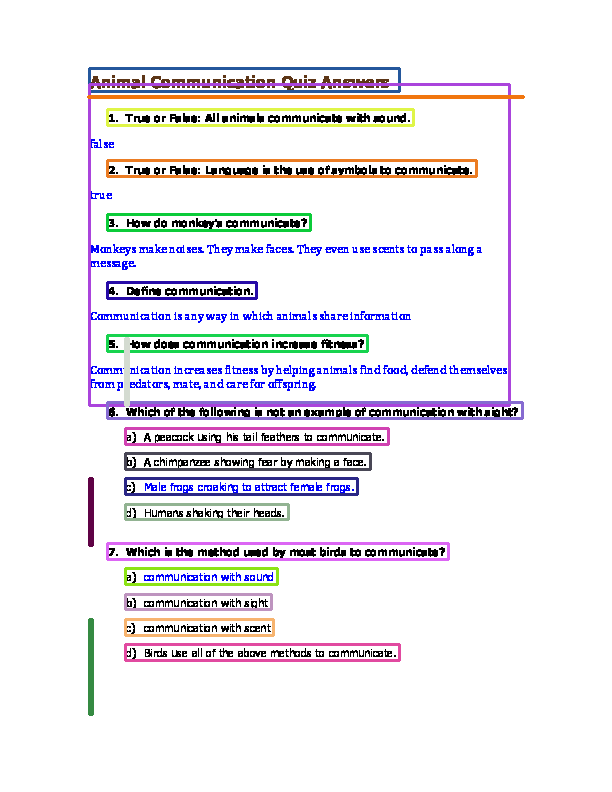

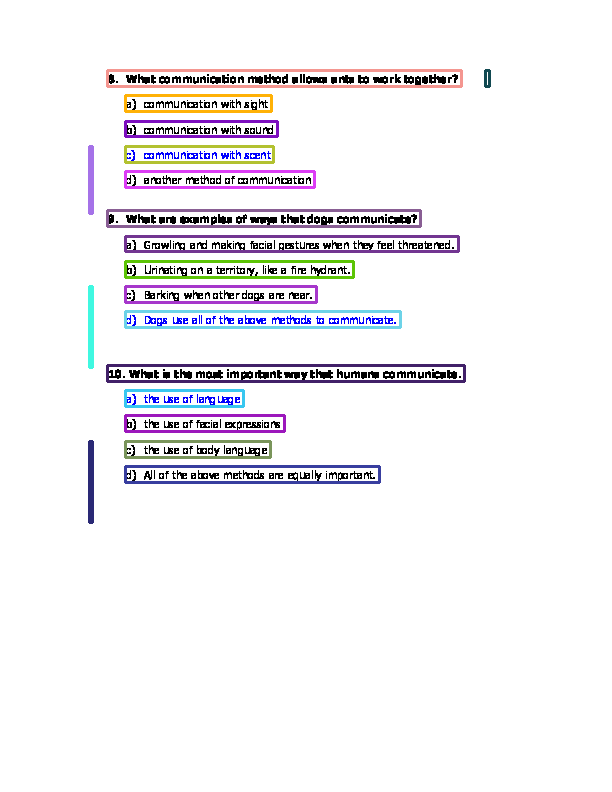

In [12]:
# pdf_processing.draw_pdf_with_boxes(test_file, [50,50])
pdf_processing.draw_pdf_with_boxes(test_file, 0)

In [28]:
ROW_BORDERS = (
    72 * 1,  # Bottom row starts 1 inch from the bottom of the page
    72 * 3,  # Second row starts 3 inches from the bottom of the page
    72 * 5,  # Third row starts 5 inches from the bottom of the page
    72 * 7,  # Third row ends 7 inches from the bottom of the page
)
COLUMN_BORDERS = (
    72 * 8,  # Third col ends 8 inches from the left of the page
    72 * 6,  # Third col starts 6 inches from the left of the page
    72 * 4,  # Second col starts 4 inches from the left of the page   
    72 * 2,  # First col starts 2 inches from the left of the page
)  # reversed so that BOXES is ordered properly
BOXES = [
    (left, bot, right, top)
    for top, bot in zip(ROW_BORDERS, ROW_BORDERS[1:])
    for left, right in zip(COLUMN_BORDERS, COLUMN_BORDERS[1:])
]

def extract_output(page):
    """
    Reads the text from page and splits it into the 9 cells.

    Returns a list with 9 entries: 

        [A, B, C, D, E, F, G, H, I]

    Each item in the tuple contains a string with all of the
    text found in the cell.

    """
    res = []
    for box in BOXES:
        strings = list(page.letterings.iter_in_bbox(box))
        # We sort from top-to-bottom and then from left-to-right, based
        # on the strings' top left corner
        strings.sort(key=lambda x: (-x.bbox[3], x.bbox[0]))
        res.append(" ".join(strings).replace(u"\xa0", " ").strip())
    return res

In [24]:
content = []
doc = minecart.Document(open(test_file, 'rb'))

In [9]:
# for page in doc.iter_pages():
#     content.append(extract_output(page))

In [37]:
import poppler

ImportError: No module named poppler

In [33]:
import ctypes
import sys
import os.path
import poppler_page
lib_poppler = ctypes.cdll.LoadLibrary("/usr/local/Cellar/poppler/0.37.0/lib/libpoppler-glib.8.dylib")
 
ctypes.pythonapi.PyCapsule_GetPointer.restype = ctypes.c_void_p
ctypes.pythonapi.PyCapsule_GetPointer.argtypes = [ctypes.py_object, ctypes.c_char_p]
PyCapsule_GetPointer = ctypes.pythonapi.PyCapsule_GetPointer
 
class Poppler_Rectangle(ctypes.Structure):
    _fields_ = [ ("x1", ctypes.c_double), ("y1", ctypes.c_double), ("x2", ctypes.c_double), ("y2", ctypes.c_double) ]
LP_Poppler_Rectangle = ctypes.POINTER(Poppler_Rectangle)
poppler_page_get_text_layout = ctypes.CFUNCTYPE(ctypes.c_int, 
                                                ctypes.c_void_p, 
                                                ctypes.POINTER(LP_Poppler_Rectangle), 
                                                ctypes.POINTER(ctypes.c_uint)
                                                )(lib_poppler.poppler_page_get_text_layout)
 
def get_page_layout(page):
    assert isinstance(page, Poppler.Page)
    capsule = page.__gpointer__
    page_addr = PyCapsule_GetPointer(capsule, None)
    rectangles = LP_Poppler_Rectangle()
    n_rectangles = ctypes.c_uint(0)
    has_text = poppler_page_get_text_layout(page_addr, ctypes.byref(rectangles), ctypes.byref(n_rectangles))
    try:
        result = []
        if has_text:
            assert n_rectangles.value > 0, "n_rectangles.value > 0: {}".format(n_rectangles.value)
            assert rectangles, "rectangles: {}".format(rectangles)
            for i in range(n_rectangles.value):
                r = rectangles[i]
                result.append((r.x1, r.y1, r.x2, r.y2))
        return result
    finally:
        if rectangles:
            GLib.free(ctypes.addressof(rectangles.contents))
 
def main():
    
    print 'Version:', Poppler.get_version()
    path= test_file
    if not os.path.isabs(path):
        path=os.path.join(os.getcwd(), path)
    d=Poppler.Document.new_from_file('file:'+path)
    n=d.get_n_pages()
    for pg_no in range(n):
        p=d.get_page(pg_no)
        print 'Page %d' % (pg_no+1), 'size ', p.get_size()
        text=p.get_text().decode('UTF-8')
        locs=get_page_layout(p)
        fonts=p.get_text_attributes()
        offset=0
        cfont=0
        for line in text.splitlines(True):
            print ' ', line.encode('UTF-8'),
            n=len(line)
            for i in range(n):
                if line[i]==u'\n':
                    continue
                font=fonts[cfont]
                while font.start_index > i+offset or font.end_index < i+offset:
                    cfont+=1
                    if cfont>= len(fonts):
                        font=None
                        break
                    font=fonts[cfont]
                
                bb=locs[offset+i]
                print line[i].encode('UTF-8'), '(%0.2f, %0.2f, %0.2f, %0.2f)' % bb,
                if font:
                    print font.font_name, font.font_size, 'r=%d g=%d, b=%d'%(font.color.red, font.color.green, font.color.blue),
            offset+=n
            print       
        print
        #p.free_text_attributes(fonts)

In [18]:
import pdfparser.poppler as pdf
import sys

In [19]:
d=pdf.Document(test_file)
 
# print 'No of pages', d.no_of_pages
for p in d:
#     print 'Page', p.page_no, 'size =', p.size
    for f in p:
#         print ' '*1,'Flow'
        for b in f:
#             print ' '*2,'Block', 'bbox=', b.bbox.as_tuple()
            for l in b:
#                 print ' '*3, l.text.encode('UTF-8'), '(%0.2f, %0.2f, %0.2f, %0.2f)'% l.bbox.as_tuple()
                #assert l.char_fonts.comp_ratio < 1.0
#                 print list(l.char_fonts)[0]
                for i in range(1):
#                     print l.text[i].encode('UTF-8'), '(%0.2f, %0.2f, %0.2f, %0.2f)'% l.char_bboxes[i].as_tuple(),\
#                         print'(%0.2f, %0.2f, %0.2f, %0.2f)'% , \
                    print l.text, l.char_fonts[i].size, l.char_fonts[i].color
#                         l.char_fonts[i].name, l.char_fonts[i].size, l.char_fonts[i].color,
#                     print '\n'
                print

Animal Communication Quiz Answers 15.84 r:0.09 g:0.21, b:0.36

1. True or False: All animals communicate with sound. 10.8 r:0.00 g:0.00, b:0.00

false	12.0 r:1.00 g:0.00, b:0.00

2. True or False: Language is the use of symbols to communicate. 10.8 r:0.00 g:0.00, b:0.00

true	12.0 r:1.00 g:0.00, b:0.00

	12.0 r:0.00 g:0.00, b:0.00

3. How do monkey’s communicate? 10.8 r:0.00 g:0.00, b:0.00

Monkeys	make	noises.	They	make	faces.	They	even	use	scents	to	pass	along	a	12.0 r:1.00 g:0.00, b:0.00

message.	12.0 r:1.00 g:0.00, b:0.00

	12.0 r:0.00 g:0.00, b:0.00

4. Define communication. 10.8 r:0.00 g:0.00, b:0.00

Communication	is	any	way	in	which	animals	share	information	12.0 r:1.00 g:0.00, b:0.00

	12.0 r:0.00 g:0.00, b:0.00

5. How does communication increase fitness? 10.8 r:0.00 g:0.00, b:0.00

Communication	increases	fitness	by	helping	animals	find	food,	defend	themselves	12.0 r:1.00 g:0.00, b:0.00

from	predators,	mate,	and	care	for	offspring.	12.0 r:1.00 g:0.00, b:0.00

	12.0 r:0.00 

In [62]:
tbbb = l.char_bboxes[0]

In [64]:
tbbb.as_tuple()

(547.091, 760.0349916, 552.54555, 773.1804571)

848

## extracting and refining

In [129]:
parsed_quizes = {}
for subject in subject_dirs:
    parsed_quizes[subject] = {}
    subject_path = os.path.join(quiz_path + subject)
#     print subject_path
    parsed_quizes[subject] = ck_ex.parse_pdf_collection(subject_path)

In [122]:
parsed_quizes.keys()

['earth-science', 'life-science', 'physical-science']

In [124]:
with open('all_parsed_quiz_questions_v1.json', 'w') as f:
    json.dump(parsed_quizes, f, indent=4, sort_keys=True)

In [101]:
for subject, quizes in parsed_quizes.items():
    ck_ex.simple_quiz_parser_test(quizes)

In [123]:
parsed_quizes['life-science']['birds']

{'questions': {'diagramQuestions': {},
  'nonDiagramQuestions': OrderedDict([('q01',
                OrderedDict([('id', 'q01'),
                             ('idStructural', '1.'),
                             ('beingAsked',
                              {'processedText': 'a key feature of all birds is flight.',
                               'rawText': u'1. True or False: A key feature of all birds is flight.'}),
                             ('correctAnswer', {'processedText': 'false'}),
                             ('type', 'True or False'),
                             ('answerChoices',
                              {'a': {'idStructural': 'a.',
                                'processedText': 'true',
                                'rawText': 'a. true'},
                               'b': {'idStructural': 'b.',
                                'processedText': 'false',
                                'rawText': 'b. false'}})])),
               ('q02',
                OrderedDict([(

In [128]:
parsed_quizes['earth-science']['oceancontinent convergent plate boundaries']['title']

'oceancontinent convergent plate boundaries'

## investigating failures

In [535]:
# parsed_content.values()[0]['question_components']['Q_2']

ex_q_to_examine = {}
for quiz1 in parsed_content.values():
    if quiz1['title'] == 'seawater chemistry':
        
        ex_q_to_examine.update(quiz1['question_components'].items())

ex_q_to_examine

In [466]:
parsed_content, proc_files = ck_ex.parse_pdf_collection(base_dir + all_dir)

energy conservation
development of theories


In [465]:
set(quiz_names).difference(set(proc_files))

{'/Users/schwenk/wrk/science_tb_anno/ck12/pdf_quizzes/earth-science/Reducing-Greenhouse-Gas-Pollution-Quiz-Answer-Key.pdf'}

In [460]:
print len(parsed_content)

846


Evolution-Plate-Tectonics-and-Climate-Change-Quiz-Answer-Key

Geothermal-Power-Quiz-Answer-Key

Location-and-Direction-Quiz-Answer-Key

Nitrogen-Cycle-in-Ecosystems-Quiz-Answer-Key

Reducing-Greenhouse-Gas-Pollution-Quiz-Answer-Key

Surface-Features-of-the-Sun-Quiz-Answer-Key

Connecting-Cellular-Respiration-and-Photosynthesis-Quiz-MS-LS-Answer-Key

Pedigree-Analysis-Quiz-MS-LS-Answer-Key

Preventing-Noninfectious-Diseases-Quiz-MS-LS-Answer-Key

Punnett-Squares-Quiz-MS-LS-Answer-Key

Velocity-Quiz-MS-PS-Answer-Key

In [431]:
! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/earth-science/Nitrogen-Cycle-in-Ecosystems-Quiz-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/earth-science/Evolution-Plate-Tectonics-and-Climate-Change-Quiz-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/earth-science/Geothermal-Power-Quiz-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/earth-science/Location-and-Direction-Quiz-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/earth-science/Reducing-Greenhouse-Gas-Pollution-Quiz-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/earth-science/Surface-Features-of-the-Sun-Quiz-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/life-science/Connecting-Cellular-Respiration-and-Photosynthesis-Quiz-MS-LS-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/life-science/Pedigree-Analysis-Quiz-MS-LS-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/life-science/Preventing-Noninfectious-Diseases-Quiz-MS-LS-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/life-science/Punnett-Squares-Quiz-MS-LS-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

! cp /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/physical-science/Velocity-Quiz-MS-PS-Answer-Key.docx /Users/schwenk/wrk/science_tb_anno/ck12/docx_quizes/test_set/

## refining parsed results

In [95]:
test_parsed_content = deepcopy(parsed_content)
ck_ex.refine_parsed_quizzes(test_parsed_content)

In [96]:
ck_ex.simple_quiz_parser_test(test_parsed_content)

In [15]:
def check_missing(parsed_quizzes):
    for quiz_n, quiz in parsed_quizzes.items():
        for qid, quest in quiz['question_components'].items():
            if quest['correct_answer'] == '_MISSING_':
                print quiz_n
check_missing(test_parsed_content)

In [97]:
with open('parsed_quiz_questions_new.json', 'w') as f:
    json.dump(test_parsed_content, f, indent=4, sort_keys=True)

## counting question types

In [644]:
type_series = [[question['question_type'] for question in quiz['question_components'].values()] for quiz in test_parsed_content.values()]

flattented_type_series = [qt for q in type_series for qt in q]

In [646]:
print sum(pd.Series(flattented_type_series).value_counts())
pd.Series(flattented_type_series).value_counts()

8475


Multiple Choice      3893
True/False           2143
Short Answer         1613
Fill-in-the-Blank     826
dtype: int64

In [647]:
q_number_series = [[question['ask']['structural_id'] for question in quiz['question_components'].values()] for quiz in test_parsed_content.values()]

In [648]:
flattened_q_number_series = [qt for q in q_number_series for qt in q]
pd.Series(flattened_q_number_series).value_counts()

5.     565
1.     565
10.    565
3.     565
2.     565
6.     564
4.     564
9.     564
7.     564
8.     563
9)     284
2)     283
8)     283
5)     283
1)     283
4)     283
3)     283
10)    282
7)     282
6)     282
11.      1
11)      1
12.      1
dtype: int64

In [611]:
flattened_q_number_series = [qt.replace('.', '').replace(')', '') for q in q_number_series for qt in q]
pd.Series(flattened_q_number_series).value_counts()

5     848
2     848
9     848
1     848
3     848
10    847
4     847
7     846
6     846
8     846
11      2
12      1
dtype: int64

In [649]:
letter_answer_series = [[question['answer_choices'].keys() for question in quiz['question_components'].values()] for quiz in test_parsed_content.values()]

flattened_letter_answer_series = [qt for q in letter_answer_series for qt in q]
flattened_letter_answer_series = [qt for q in flattened_letter_answer_series for qt in q]

flattened_letter_answer_series
pd.Series(flattened_letter_answer_series).value_counts()

answer_choice a)    6017
answer_choice b)    6015
answer_choice d)    3908
answer_choice c)    3908
answer_choice e)       5
answer_choice f)       3
answer_choice h)       1
answer_choice g)       1
dtype: int64

### old run below

In [376]:
print sum(pd.Series(flattented_type_series).value_counts())
pd.Series(flattented_type_series).value_counts()

8402


Multiple Choice    3839
Short Answer       2441
True/False         2120
None                  2
dtype: int64

the two question with None type are MC questions with mistakes in the original docx

one has d) as a choice twice

the other has a c. instead of c)

In [82]:
ex_q_to_examine = {}
for quiz1 in test_parsed_content.values():
    ex_q_to_examine.update({quiz1['title']:v for k, v in quiz1['question_components'].items() if isinstance(v, str) or 'question_type' not in v.keys() or v['question_type'] == 'None'})

In [83]:
ex_q_to_examine

{'chemical properties of matter': OrderedDict([('question_id', 'Q_9'),
              ('ask',
               {'contents': '9. which of these substances is least flammable?'}),
              ('answer_choices',
               OrderedDict([('answer_choice a)', {'contents': 'a) cardboard'}),
                            ('answer_choice b)',
                             {'contents': 'b) paper c. charcoal'}),
                            ('answer_choice d)', {'contents': 'd) steel'})])),
              ('question_type', 'None'),
              ('correct_answer', 'd) steel')]),
 'covalent bonding': OrderedDict([('question_id', 'Q_6'),
              ('ask',
               {'contents': '6. elements that form diatomic molecules include'}),
              ('answer_choices',
               OrderedDict([('answer_choice a)', {'contents': 'a) oxygen.'}),
                            ('answer_choice b)', {'contents': 'b) hydrogen.'}),
                            ('answer_choice d)',
                         

## finding stopwords

In [432]:
quiz_titles = parsed_content.keys()

In [433]:
len(quiz_titles)

839

In [435]:
title_corpus = ' '.join(quiz_titles)

In [436]:
title_feq_dist = nltk.FreqDist(title_corpus.split())
most_common_words = title_feq_dist.most_common()
filter_words = [word[0].lower() for word in most_common_words[:4]]
filter_words

['of', 'and', 'the', 'system']

original run (prior to filtering) below

In [145]:
title_feq_dist = nltk.FreqDist(title_corpus.split())
most_common_words = title_feq_dist.most_common()
filter_words = [word[0].lower() for word in most_common_words[:4]]
filter_words

[u'quiz', u'answer', u'key', u'answers']

In [437]:
# most_common_words = title_feq_dist.most_common()

## font color and size counts

In [71]:
colors_seen, sizes_seen = test_parser.parse_pdf_collection(base_dir + all_dir)

In [65]:
colors_seen

{(0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0),
 (0.0901947021484375, 0.211761474609375, 0.3647003173828125),
 (1.0, 0.0, 0.0)}

In [66]:
sizes_seen

{6.996890015500003,
 7.141352035799999,
 7.2992101224,
 10.8,
 11.132385189167685,
 12.000000000000002,
 12.264581926999998,
 12.270621905999995,
 12.513388832,
 14.88,
 15.840000000000002}

In [72]:
pd.value_counts(colors_seen)

(0.0, 0.0, 0.0)                                      30557
(1.0, 0.0, 0.0)                                       9595
(0.0901947021484, 0.211761474609, 0.364700317383)      842
(0.0, 0.0, 1.0)                                          1
dtype: int64

In [73]:
pd.value_counts(sizes_seen)

10.800000    34363
12.000000     5721
15.840000      855
11.132385       20
7.141352        16
12.270622        8
7.299210         4
12.513389        2
14.880000        2
12.264582        2
6.996890         2
dtype: int64

# End

In [23]:
for lesson, topic in tpp.items():
    print lesson * 6
    for topic, text in topic.items():
        print topic
        print text
        print '\n' * 3